In [1]:
from PATH import data_path
import os
import pandas as pd
import numpy as np
import json
path=os.path.join(data_path,'meta_data/')
import matplotlib.pyplot as plt

In [41]:
json_files = [os.path.join(path,file) for file in os.listdir(path)]
json_files = list(filter(lambda x: '.json' in x,json_files))

In [18]:
def extract_info(Dict):
    '''
    from json dict extract info and return in the ordre of 
    ['file_submitter','experimental_strategy','platform','workflow_version','analysis_submitter_id',\
    'analysis_id','workflow_type','entity_id','entity_type','entity_submitter_id']
    '''
    file_submitter = Dict['submitter_id']
    
    assert(len(Dict['analysis']['input_files'])==1)
    infiles = Dict['analysis']['input_files'][0]
    experimental_strategy = infiles['experimental_strategy']
    platform = infiles['platform']
    
    workflow_version = Dict['analysis']['workflow_version']
    analysis_submitter_id = Dict['analysis']['submitter_id']
    analysis_id = Dict['analysis']['analysis_id']
    workflow_type =  Dict['analysis']['workflow_type']
    
    assert(len(Dict['associated_entities'])==1)
    as_entities = Dict['associated_entities'][0]
    entity_id = as_entities['entity_id']
    entity_type = as_entities['entity_type']
    entity_submitter_id = as_entities['entity_submitter_id']
    
    return [file_submitter,experimental_strategy,platform,workflow_version,analysis_submitter_id,\
            analysis_id,workflow_type,entity_id,entity_type,entity_submitter_id]

In [21]:
info_name = ['file_submitter','experimental_strategy','platform','workflow_version','analysis_submitter_id','analysis_id','workflow_type','entity_id','entity_type','entity_submitter_id']

In [34]:
def json2DF(Json):
    
    meta_data = np.stack([extract_info(Dict) for Dict in Json])
    meta_DF = pd.DataFrame(meta_data,columns=info_name)
    return meta_DF.set_index('entity_submitter_id')

In [38]:
merged_df = json2DF(j0)

In [42]:
for i in range(1,len(json_files)):
    with open(json_files[i],'r') as f:
        Json = json.load(f)
    
    merged_df = merged_df.append(json2DF(Json))

In [43]:
merged_df.shape

(10537, 9)

In [44]:
merged_df.to_csv(os.path.join(data_path,'meta_info.csv'),index=True)

In [46]:
nmb_of_uniq = lambda x : len(np.unique(x))

In [47]:
unique_statistics=[nmb_of_uniq(merged_df.iloc[:,i]) for i in range(merged_df.shape[1])]

In [48]:
unique_statistics

[6267, 1, 1, 1, 6267, 6267, 1, 6267, 1]

In [61]:
for i in range(len(info_name)):
    print('# of unique value {} \t \t is  {} '.format(info_name[i],unique_statistics[i]))

# of unique value file_submitter 	 	 is  6267 
# of unique value experimental_strategy 	 	 is  1 
# of unique value platform 	 	 is  1 
# of unique value workflow_version 	 	 is  1 
# of unique value analysis_submitter_id 	 	 is  6267 
# of unique value analysis_id 	 	 is  6267 
# of unique value workflow_type 	 	 is  1 
# of unique value entity_id 	 	 is  6267 
# of unique value entity_type 	 	 is  1 


## The DSC metric  

Dispersion Separability Criterion (DSC) is a new metric that has been designed to quantify the amount of batch effect in the data. It is based on a similar metric, the Scatter Separability Criterion. DSC is defined as:

$$DSC = D_b/D_w$$

Where $D_b$ is a measure of dispersion between batches (or other groupings of the data), and $D_w$ is a measure of dispersion within batches. Therefore, DSC is a ratio of between batch dispersion vs. within batch dispersion. More precisely, $D_b$ is defined as:

$$ D_b = \sqrt{trace(S_b)} $$

and $D_w$ is defined as:

$$ D_w = \sqrt{trace(S_w)} $$

Where $S_b$ is the “between batch” scatter matrix, and Sw is the “within batch” scatter matrix defined in Dy et al, 2004 . $D_w$ can roughly be viewed as the average “distance” between samples within a batch and the batch mean, or centroid, whereas $D_b$ can roughly be viewed as the average distance between batch centroids and the global mean.

## Check sequence center

In [2]:
pan_cancer = pd.read_csv(os.path.join(data_path,'pan_cancer.csv')).rename({'Unnamed: 0':'ID'},axis=1)

In [7]:
get_center = lambda x: x.split('-')[-1]
center_ls = pan_cancer['ID'].apply(get_center)

#### separate data from different center

In [14]:
for i in np.unique(center_ls):
    # iter through 07 , 13 ,31
    df = pan_cancer[center_ls == i].set_index('ID').transpose()  # transpose to gene in row  and  sample in columns
    df.to_csv(os.path.join(data_path,'batch', 'center'+i+'.txt'),sep='\t',index=True) # save to txt file

#### statitics of center info

In [90]:
stats =[np.sum(center_ls == i) for i in np.unique(center_ls)]
label = np.unique(center_ls)

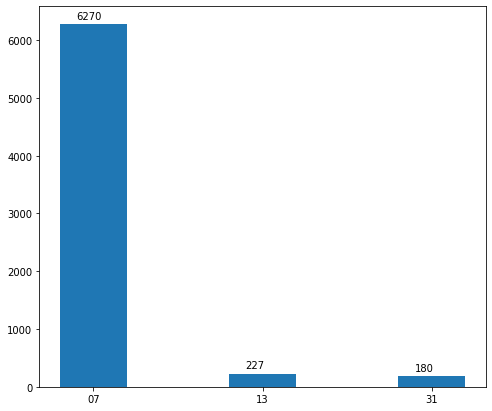

In [97]:
plt.figure(figsize=(8,7))
plt.bar(range(3),stats,width = 0.4);
for i in range(3):
    plt.text(i-0.1,stats[i]+100,s=stats[i]);
plt.xticks(range(3),np.unique(center_ls),);